In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta

In [45]:
# Define the ticker symbol
ticker = 'AAPL'

# Download historical data for the past 10 years
# Set period to '10y' for 10 years
apple_data = yf.download(ticker, period='10y', interval='1d')
closing_prices = apple_data['Close']
historical_data = closing_prices

# Display the first few rows
apple_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-06,24.987499,25.162500,24.855000,24.905001,22.113335,148204800
2014-10-07,24.857500,25.030001,24.682501,24.687500,21.920214,168376800
2014-10-08,24.690001,25.277500,24.577499,25.200001,22.375267,229618800
2014-10-09,25.385000,25.594999,25.152500,25.254999,22.424095,309506000
2014-10-10,25.172501,25.507500,25.075001,25.182501,22.359718,265326400


In [46]:
# Define moving average windows
ma_windows = [10, 25, 30]

# Calculate moving averages and add them as new columns
for window in ma_windows:
    apple_data[f'MA_{window}'] = apple_data['Close'].rolling(window=window).mean()

# Drop rows with NaN values resulting from moving average calculations
apple_data.dropna(inplace=True)

# Display the updated data
apple_data.head()

,Open,High,Low,Close,Adj Close,Volume,MA_10,MA_25,MA_30
Date,,,,,,,,,
2014-11-14,28.287500,28.547501,27.802500,28.545000,25.455219,176254400,27.53375,26.4082,26.181167
2014-11-17,28.567499,29.320000,28.325001,28.497499,25.412857,186986800,27.64850,26.5500,26.300917
2014-11-18,28.485001,28.922501,28.472500,28.867500,25.742805,176896000,27.82025,26.7172,26.440250
2014-11-19,28.860001,28.934999,28.450001,28.667500,25.564449,167476800,27.96550,26.8885,26.555833
2014-11-20,28.727501,29.215000,28.712500,29.077499,25.930071,173582000,28.15575,27.0890,26.683250


In [47]:
# Shift the 'Close' column by -1 to create the target variable (next day's price)
apple_data['Target'] = apple_data['Close'].shift(-1)

# Drop the last row as it will have NaN in 'Target'
apple_data.dropna(inplace=True)

# Define feature columns and target
feature_cols = [f'MA_{window}' for window in ma_windows]
target_col = 'Target'

# Split data into features (X) and target (y)
X = apple_data[feature_cols]
y = apple_data[target_col]

# Display the first few rows of features and target
X.head(), y.head()

(               MA_10    MA_25      MA_30
 Date                                    
 2014-11-14  27.53375  26.4082  26.181167
 2014-11-17  27.64850  26.5500  26.300917
 2014-11-18  27.82025  26.7172  26.440250
 2014-11-19  27.96550  26.8885  26.555833
 2014-11-20  28.15575  27.0890  26.683250,
 Date
 2014-11-14    28.497499
 2014-11-17    28.867500
 2014-11-18    28.667500
 2014-11-19    29.077499
 2014-11-20    29.117500
 Name: Target, dtype: float64)

In [48]:
# Determine the split index
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

# Split into training and testing sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 1989
Testing samples: 498


In [49]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Display model coefficients
coefficients = pd.Series(model.coef_, index=feature_cols)
intercept = model.intercept_

print("Model Coefficients:")
print(coefficients)
print(f"\nIntercept: {intercept:.2f}")

Model Coefficients:
MA_10    1.482935
MA_25   -1.050784
MA_30    0.566968
dtype: float64

Intercept: 0.24


In [50]:
# Predict on training data
y_train_pred = model.predict(X_train)

# Calculate error metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

print("Training Performance:")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_train:.2f}")

Training Performance:
Mean Absolute Error (MAE): 1.79
Mean Squared Error (MSE): 8.48
Root Mean Squared Error (RMSE): 2.91


In [51]:
# Predict on testing data
y_test_pred = model.predict(X_test)

# Calculate error metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Testing Performance:")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")

Testing Performance:
Mean Absolute Error (MAE): 4.05
Mean Squared Error (MSE): 26.65
Root Mean Squared Error (RMSE): 5.16


In [52]:
# Function to perform iterative multi-step forecasting
def forecast_future_prices(model, last_known_data, ma_windows, forecast_days=365):
    """
    Forecast future stock prices using a moving average based linear regression model.

    Parameters:
    - model: Trained LinearRegression model.
    - last_known_data: pandas Series of the latest closing prices needed for moving averages.
    - ma_windows: List of integers representing moving average window sizes.
    - forecast_days: Number of future days to predict.

    Returns:
    - future_predictions: pandas Series with forecasted closing prices.
    """
    future_predictions = []
    data = last_known_data.copy()

    for _ in range(forecast_days):
        # Compute moving averages
        features = {}
        for window in ma_windows:
            if len(data) >= window:
                features[f'MA_{window}'] = data[-window:].mean()
            else:
                features[f'MA_{window}'] = np.nan  # Not enough data

        # If any feature is NaN, cannot predict
        if any(pd.isna(value) for value in features.values()):
            raise ValueError("Not enough data to compute all moving averages.")

        # Create a DataFrame for prediction
        feature_df = pd.DataFrame([features])

        # Predict the next day's price
        next_price = model.predict(feature_df)[0]

        # Append the prediction
        future_predictions.append(next_price)

        # Update the data with the predicted price
        # data = data.append(pd.Series(next_price))
        data = pd.concat([data.iloc[1:], pd.Series([next_price])], ignore_index=True)

    # Create date index for future predictions
    last_date = last_known_data.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

    # Create a pandas Series for future predictions
    future_predictions_series = pd.Series(future_predictions, index=future_dates)

    return future_predictions_series

# Get the last 'max_ma_window' closing prices from the dataset for forecasting
max_ma_window = max(ma_windows)
last_known_data = apple_data['Close'][-max_ma_window:]

# Forecast the next 365 days
future_days = 365
future_predictions = forecast_future_prices(model, last_known_data, ma_windows, forecast_days=future_days)

# Display the first few future predictions
future_predictions.head()

,0
2024-10-04,229.248917
2024-10-05,229.516389
2024-10-06,229.997025
2024-10-07,230.136074
2024-10-08,230.344055


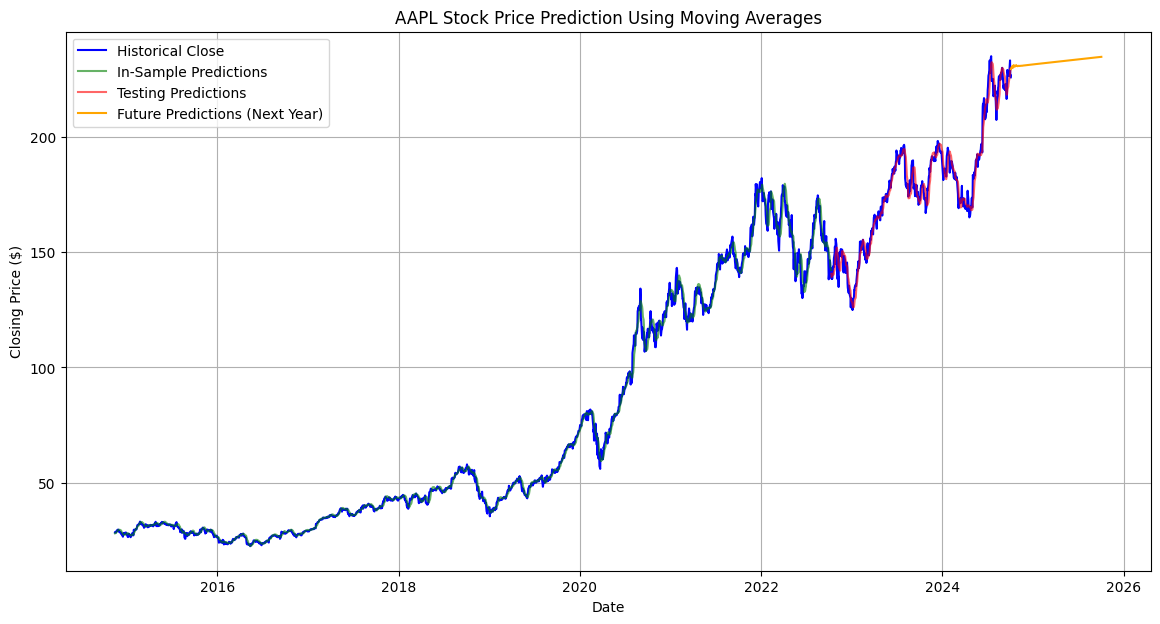

In [53]:
# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical closing prices
plt.plot(apple_data.index, apple_data['Close'], label='Historical Close', color='blue')

# Plot in-sample predictions
plt.plot(X_train.index, y_train_pred, label='In-Sample Predictions', color='green', alpha=0.6)

# Plot testing predictions
plt.plot(X_test.index, y_test_pred, label='Testing Predictions', color='red', alpha=0.6)

# Plot future predictions
plt.plot(future_predictions.index, future_predictions, label='Future Predictions (Next Year)', color='orange')

# Enhance the plot
plt.title(f"{ticker} Stock Price Prediction Using Moving Averages")
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.show()

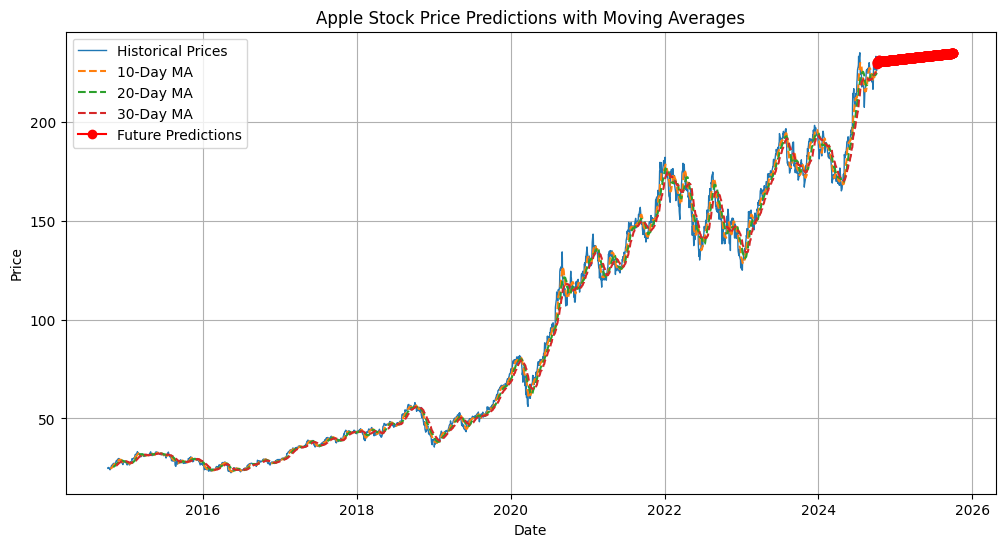

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data, label='Historical Prices', linewidth=1)
moving_avg_10 = closing_prices.rolling(10).mean()
moving_avg_20 = closing_prices.rolling(20).mean()
moving_avg_30 = closing_prices.rolling(30).mean()
prediction_index = future_predictions.index
future_forecast = future_predictions.values
plt.plot(moving_avg_10.index, moving_avg_10, label='10-Day MA', linestyle='--')
plt.plot(moving_avg_20.index, moving_avg_20, label='20-Day MA', linestyle='--')
plt.plot(moving_avg_30.index, moving_avg_30, label='30-Day MA', linestyle='--')
plt.plot(prediction_index, future_forecast, label='Future Predictions', marker='o', color='red')
plt.legend()
plt.title("Apple Stock Price Predictions with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()

In [55]:
# Predict the next day's closing price
latest_data = apple_data['Close'][-max_ma_window:]
next_day_prediction = forecast_future_prices(model, latest_data, ma_windows, forecast_days=1)

print(f"Predicted Closing Price for the Next Day ({next_day_prediction.index[0].date()}): ${next_day_prediction.values[0]:.2f}")

Predicted Closing Price for the Next Day (2024-10-04): $229.25
